# COVID-19

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
URL = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
FMT = '%Y-%m-%d %H:%M:%S'

In [3]:
print(datetime.now().strftime("%Y-%m-%d"))
print(f'{(datetime.now() - datetime.strptime("2020-01-01 00:00:00", FMT)).days} days after Jan 1st, 2020')

2020-03-16
75 days after Jan 1st, 2020


In [4]:
def logistic_model(x, a, b, c):
    return c/(1+np.exp(-(x-b)/a))

In [5]:
df = pd.read_csv(URL)
df = df.loc[:,['data', 'totale_attualmente_positivi', 'nuovi_attualmente_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi']]
date = df['data']
df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days)

In [6]:
x = np.array(df.iloc[:,0])
active_cases = np.array(df.iloc[:,1])
new_cases = np.array(df.iloc[:,2])
recovered = np.array(df.iloc[:,3])
deaths = np.array(df.iloc[:,4])
total_cases = np.array(df.iloc[:,5])
new_recovered = np.hstack([0, np.ediff1d(recovered)])
new_deaths = np.hstack([0, np.ediff1d(deaths)])
print(f'Active cases  = {active_cases[-1]}')
print(f'New cases     = {new_cases[-1]}')
print(f'Recovered     = {recovered[-1]}')
print(f'New recovered = {new_recovered[-1]}')
print(f'Deaths        = {deaths[-1]}')
print(f'New deaths    = {new_deaths[-1]}')
print(f'Total cases   = {total_cases[-1]}')

Active cases  = 23073
New cases     = 2470
Recovered     = 2749
New recovered = 414
Deaths        = 2158
New deaths    = 349
Total cases   = 27980


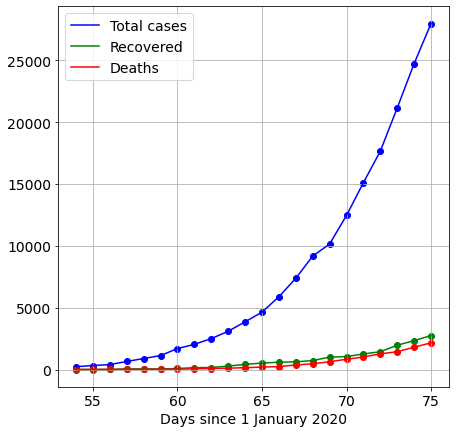

In [7]:
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
plt.scatter(x, total_cases, color='blue')
plt.plot(x, total_cases, 'b', label='Total cases')
plt.scatter(x, recovered, color='green')
plt.plot(x, recovered, 'g', label='Recovered')
plt.scatter(x, deaths, color='red')
plt.plot(x, deaths, 'r', label='Deaths')
plt.xlabel('Days since 1 January 2020')
plt.legend()
plt.grid(True)

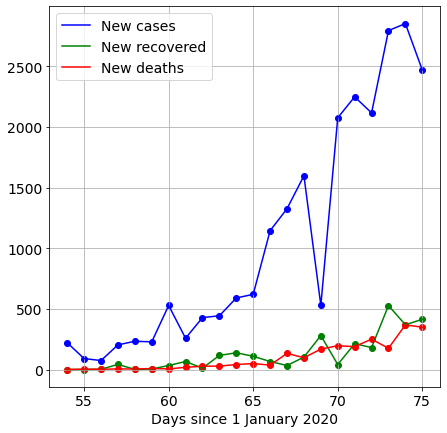

In [8]:
plt.scatter(x, new_cases, color='blue')
plt.plot(x, new_cases, 'b', label='New cases')
plt.scatter(x, new_recovered, color='green')
plt.plot(x, new_recovered, 'g', label='New recovered')
plt.scatter(x, new_deaths, color='red')
plt.plot(x, new_deaths, 'r', label='New deaths')
plt.xlabel('Days since 1 January 2020')
plt.legend()
plt.grid(True)

In [9]:
fit = curve_fit(logistic_model, x, total_cases, p0=[2, 100, 20000])
a, b, c = fit[0]
err_a, err_b, err_c = (np.sqrt(fit[1][i][i]) for i in [0, 1, 2])
sol = int(fsolve(lambda x : logistic_model(x, a, b, c) - int(c), b)[0])
print(f'Expected number of infected people = {int(c)} ± {int(err_c)}')
print(f'Expected infection peak = {int(b)} ± {int(err_b)} days after Jan 1st, 2020')
print(f'Expected infection end = {sol} days after Jan 1st, 2020')

Expected number of infected people = 67811 ± 5408
Expected infection peak = 76 ± 0 days after Jan 1st, 2020
Expected infection end = 126 days after Jan 1st, 2020


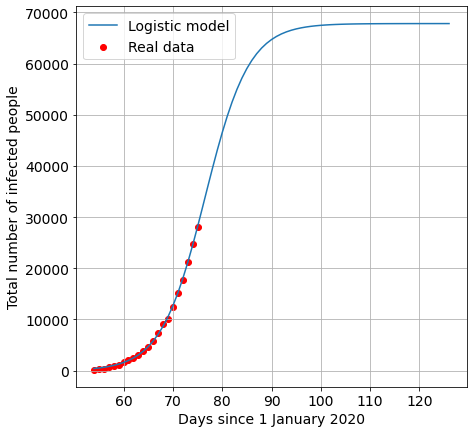

In [10]:
pred_x = np.arange(x.min(), sol+1)
pred_total_cases = np.array([logistic_model(i, a, b, c) for i in pred_x])
plt.scatter(x, total_cases, label='Real data', color='red')
plt.plot(pred_x, pred_total_cases, label='Logistic model')
plt.xlabel('Days since 1 January 2020')
plt.ylabel('Total number of infected people')
plt.legend()
plt.grid(True)

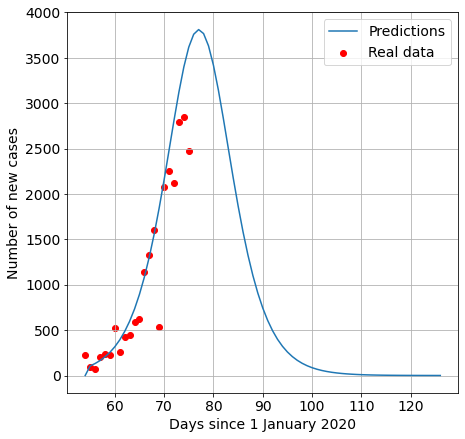

In [11]:
pred_new_cases = np.hstack([0, np.ediff1d(pred_total_cases)])
plt.scatter(x, new_cases, label='Real data', color='red')
plt.plot(pred_x, pred_new_cases, label='Predictions')
plt.xlabel('Days since 1 January 2020')
plt.ylabel('Number of new cases')
plt.legend()
plt.grid(True)